In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pylab as plt

from functools import partial
import random

from sklearn.metrics import silhouette_score, calinski_harabaz_score

DATA_DIR = '../data/clean/'

## Import and extract data

In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'subset_2yrs.csv', index_col=0)
                      .dropna(axis=1, thresh=7)).T # ONLY THOSE WITH 7 OBS
bmi_by_patient.head()

MRN   472613     584276     599209     647362     689752     728998    \
0    34.613679  34.142193  26.349156  36.193387  18.796160  31.566288   
1          NaN        NaN        NaN        NaN        NaN        NaN   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN  37.272640  18.853099        NaN   
4          NaN        NaN        NaN        NaN  19.633149        NaN   

MRN   730028     764134     794941     798124      ...       40843237  \
0    22.725041  20.755906  20.302289  24.218798    ...      23.331488   
1          NaN  21.026407  20.302289  24.205390    ...      23.636893   
2          NaN  22.908206  20.901024  22.807572    ...      24.348050   
3    23.402535        NaN        NaN  24.117025    ...      24.758165   
4          NaN        NaN        NaN        NaN    ...      25.142103   

MRN   40846107   40865255   40868465   40879033   40891764   95586095  \
0    26.138390  20.099921  29.637929  22.594038  24.084359  25.616987   
1    24.515531  19.999990  30.576244  22.151273  22.838821        NaN   
2    24.722705  19.777068  31.276793  22.764958  21.288818        NaN   
3    25.534134  19.753086  32.096226  23.036803  21.359046        NaN   
4    25.620457  19.678675  32.008594  23.036803  22.441817        NaN   

MRN   96193156   96505185   96796297  
0    33.470148  34.853982  24.807863  
1    34.011028        NaN  26.608833  
2          NaN        NaN        NaN  
3          NaN        NaN  27.426742  
4    32.062296        NaN        NaN  

[5 rows x 72616 columns]

In [3]:
bmi_by_patient.shape

(24, 72616)

## Estimate continuous time series using interpolation

In [4]:
D, N = bmi_by_patient.shape
D, N

(24, 72616)

In [5]:
X = np.arange(D).reshape(-1, 1)

In [6]:
data_centered = bmi_by_patient - bmi_by_patient.iloc[0]
data_centered.head()

MRN  472613    584276    599209    647362    689752    728998    730028    \
0         0.0       0.0       0.0  0.000000  0.000000       0.0  0.000000   
1         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3         NaN       NaN       NaN  1.079252  0.056939       NaN  0.677494   
4         NaN       NaN       NaN       NaN  0.836989       NaN       NaN   

MRN  764134    794941    798124      ...     40843237  40846107  40865255  \
0    0.000000  0.000000  0.000000    ...     0.000000  0.000000  0.000000   
1    0.270502  0.000000 -0.013408    ...     0.305405 -1.622859 -0.099931   
2    2.152300  0.598735 -1.411227    ...     1.016562 -1.415686 -0.322853   
3         NaN       NaN -0.101774    ...     1.426678 -0.604256 -0.346835   
4         NaN       NaN       NaN    ...     1.810615 -0.517934 -0.421247   

MRN  40868465  40879033  40891764  95586095  96193156  96505185  96796297  
0    0.000000  0.000000  0.000000       0.0  0.000000       0.0  0.000000  
1    0.938315 -0.442765 -1.245538       NaN  0.540880       NaN  1.800970  
2    1.638865  0.170920 -2.795541       NaN       NaN       NaN       NaN  
3    2.458297  0.442765 -2.725313       NaN       NaN       NaN  2.618879  
4    2.370665  0.442765 -1.642542       NaN -1.407851       NaN       NaN  

[5 rows x 72616 columns]

In [7]:
y = data_centered.T.values

In [8]:
from scipy.interpolate import PchipInterpolator

In [9]:
def interpolate(row, extrapolate=False):
    
    non_missing = row.dropna()
    y_interp = PchipInterpolator(non_missing.index.values.astype(int), 
                                 non_missing.values, 
                                 extrapolate=extrapolate)(row.index.values.astype(int))
    
    return pd.Series(y_interp)

In [10]:
data_interpolated = data_centered.apply(interpolate, axis=0).fillna(method='ffill')

In [11]:
data_interpolated.shape

(24, 72616)

## Create clusters using K-means with soft-DTW distances

We will use a k-means clustering algorithm, based on dynamic time warping (DTW) as a distance metric. Unlike the Euclidean distance, DTW is able to compare asynchronous time series of varying size and is robust to elastic transformations in time. To be robust to such invariances, DTW computes a minimal cost alignment between time series using dynamic programming.

Soft-DTW is a formulation of DTW that computes the soft-minimum of all alignment costs, resulting in a differentiable loss function.

In [12]:
from tslearn.clustering import TimeSeriesKMeans

In [13]:
from ipyparallel import Client

rc = Client()

In [14]:
dv = rc[:]

In [28]:
def run_cluster(n_clusters, data, gamma=0.1):
    from tslearn.clustering import TimeSeriesKMeans
    sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma_sdtw": gamma},
                           verbose=True)
    y_pred_sdtw = sdtw_km.fit_predict(data)
    return sdtw_km, y_pred_sdtw

In [16]:
results = dv.map(run_cluster, (6, 8, 10, 12), [data_interpolated.T.values]*4)

In [17]:
results_6, results_8, results_10, results_12 = results.get()

In [41]:
foo, bar = results_6

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [46]:
from tslearn.metrics import soft_dtw

In [ ]:
score_6 = silhouette_score(data_interpolated.T.values, bar, metric=soft_dtw)

## Evaluate cluster number

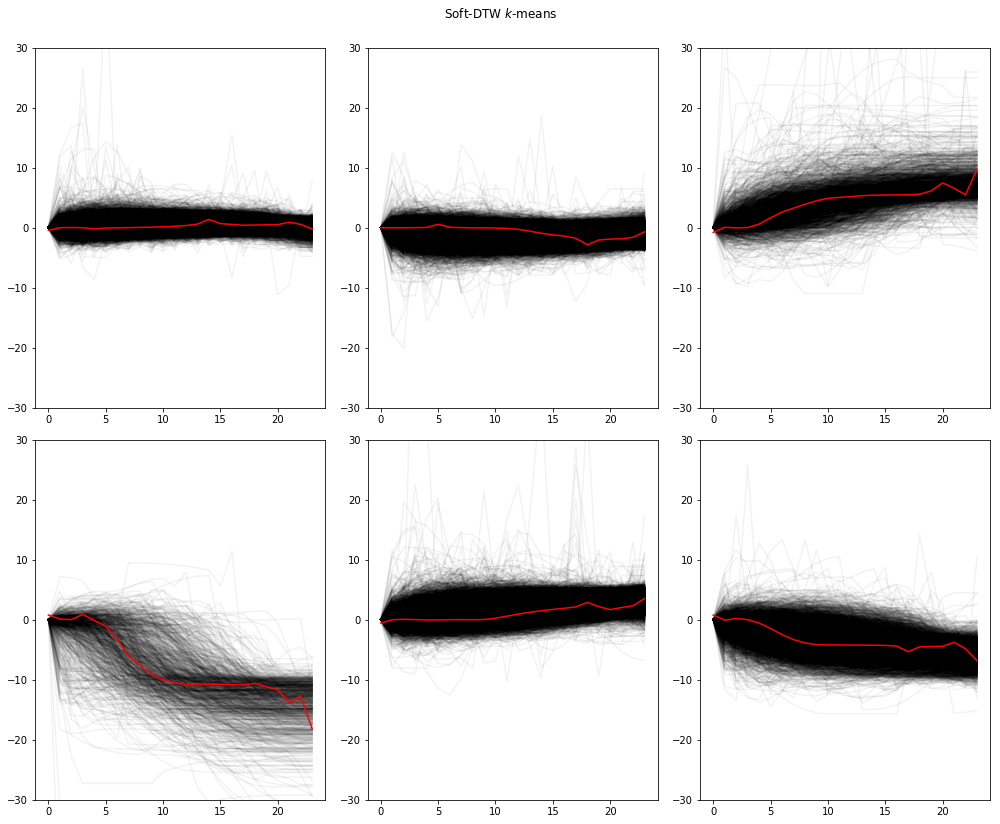

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(14,12))
model, y_pred = results_6
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
    ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

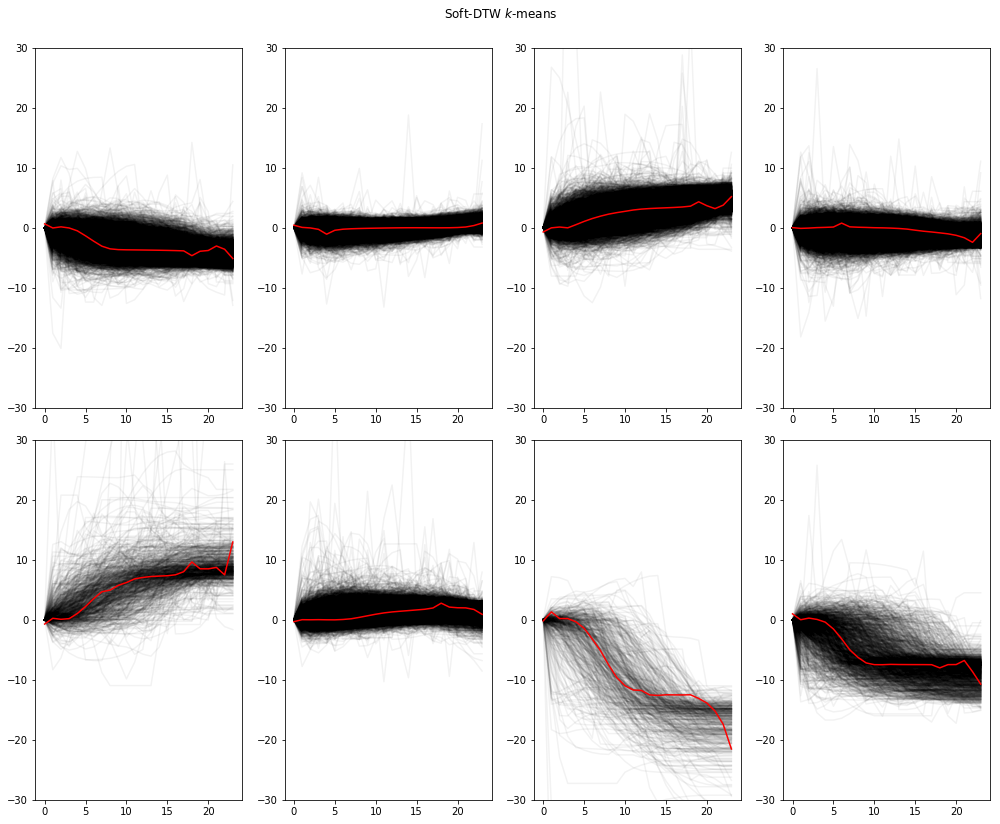

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(14,12))
model, y_pred = results_8
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
    ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

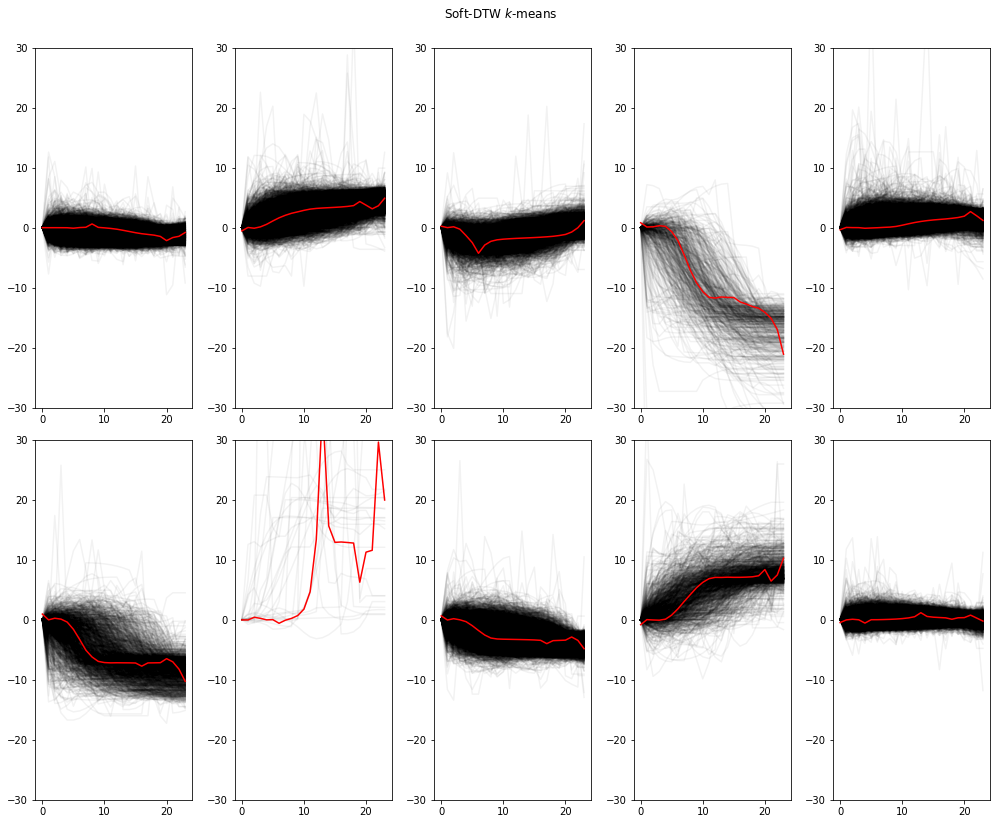

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(14,12))
model, y_pred = results_10
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
    ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

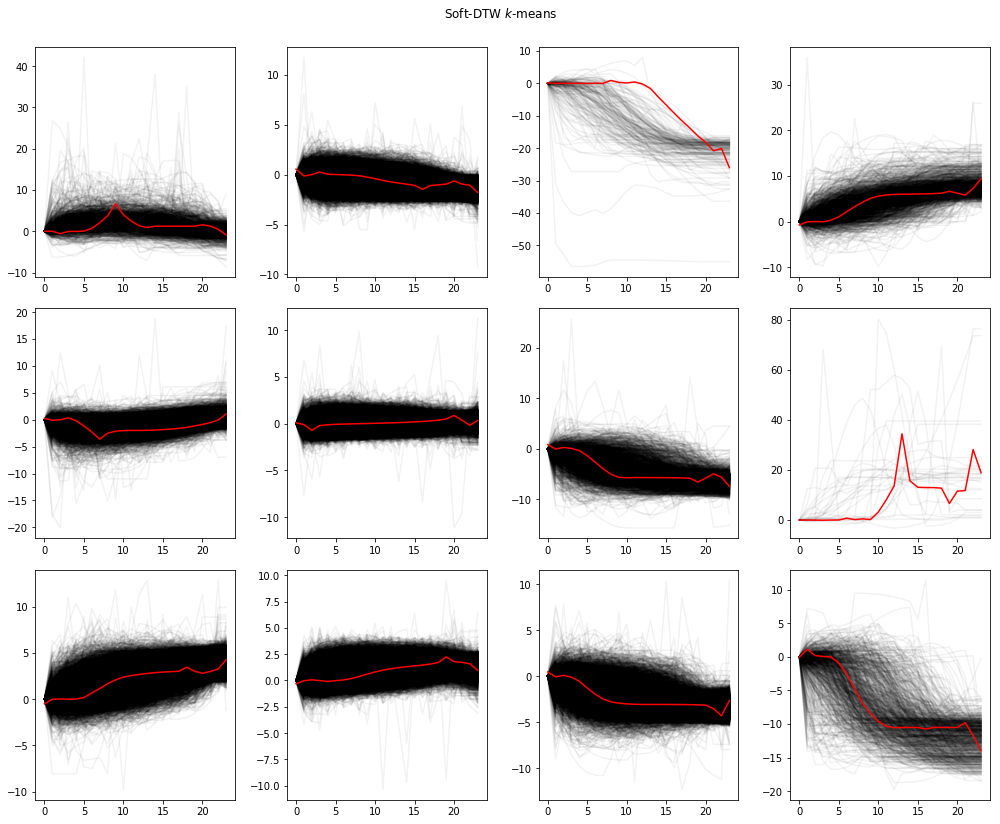

In [36]:
fig, axes = plt.subplots(3, 4, figsize=(14,12))
model, y_pred = results_12
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
#     ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Evaluate smoothing parameter

Run 8-cluster models under $\gamma$ values of 0.01, 0.1 and 1.

In [48]:
results_gamma = dv.map(run_cluster, [8]*3, [data_interpolated.T.values]*3, [0.01, 0.1, 1])

In [49]:
results_001, results_01, results_1 = results_gamma.get()

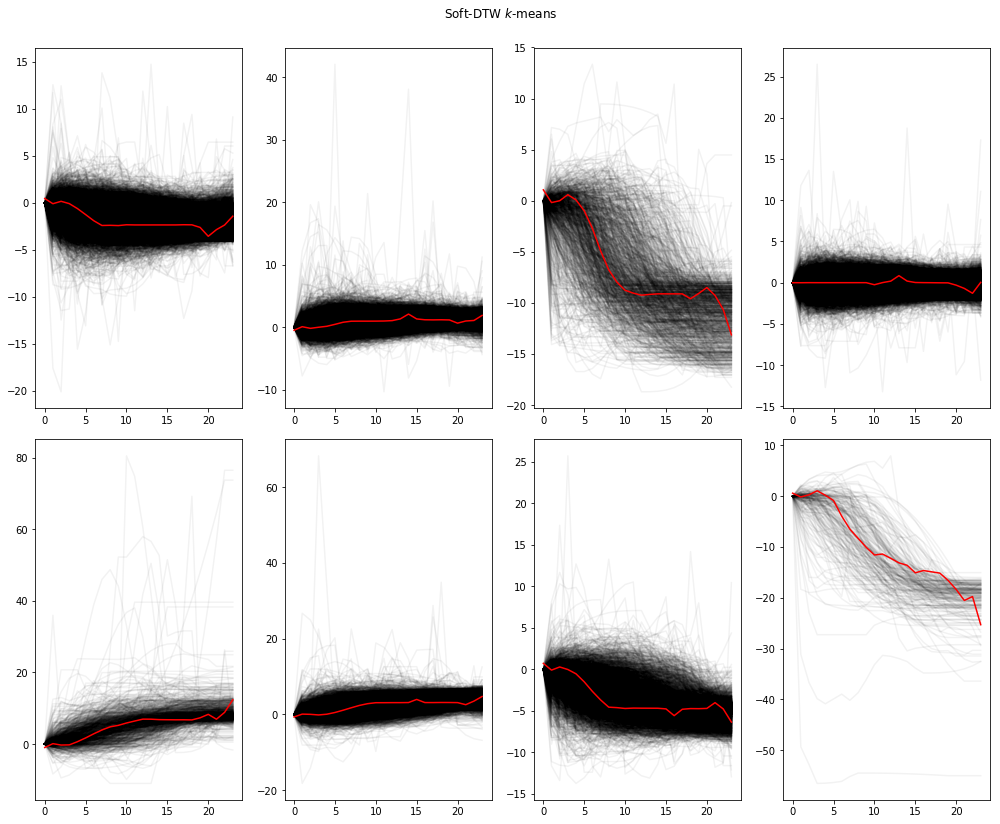

In [53]:
fig, axes = plt.subplots(2, 4, figsize=(14,12))
model, y_pred = results_001
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
    #ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

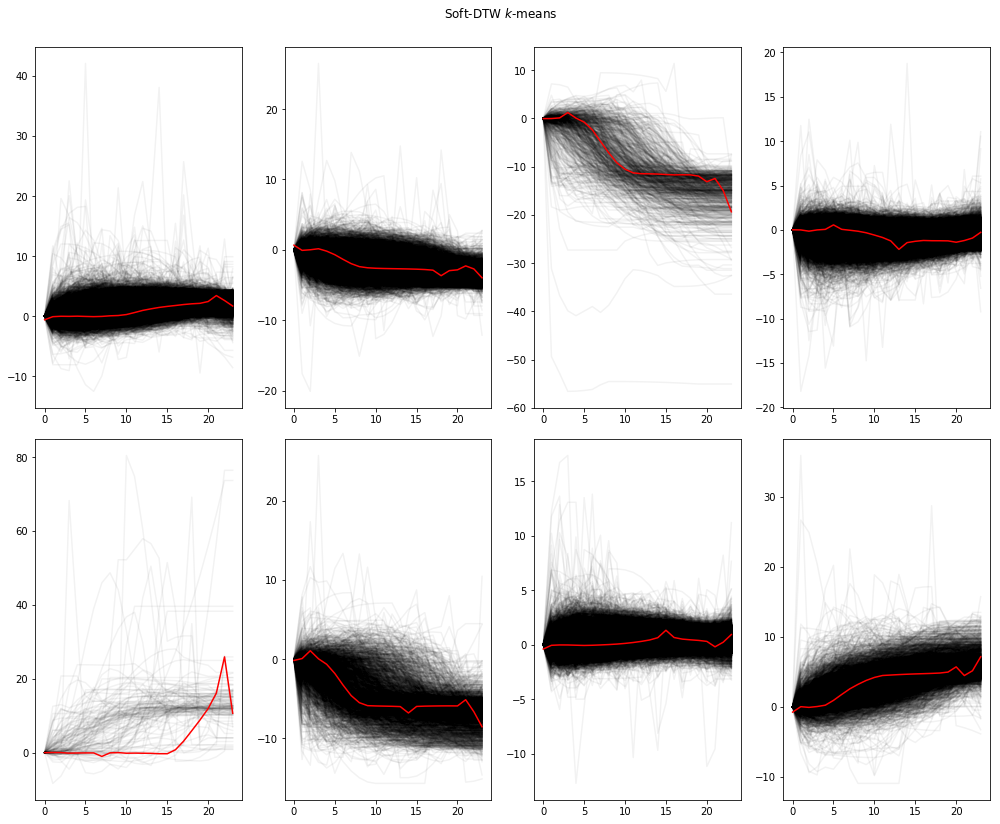

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(14,12))
model, y_pred = results_01
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
    #ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

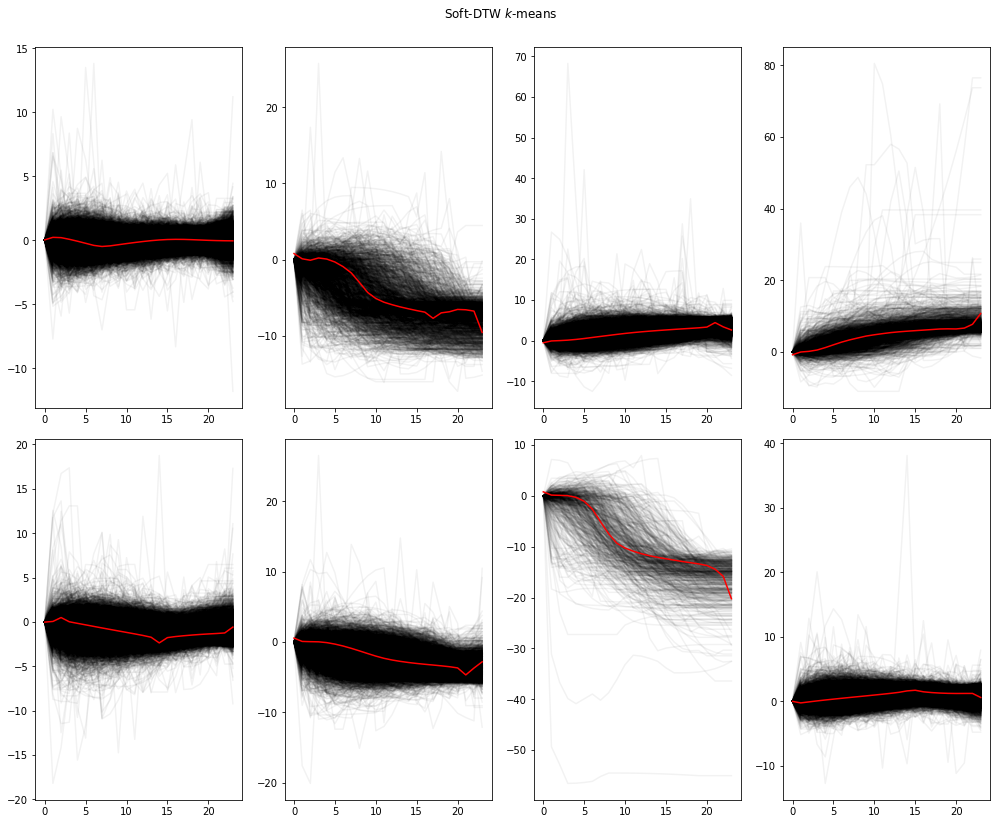

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(14,12))
model, y_pred = results_1
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(model.cluster_centers_[i].ravel(), "r-")
    #ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [13]:
n_clusters = 8

sdtw_8 = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma_sdtw": 0.11},
                           verbose=True)
y_pred_sdtw_8 = sdtw_8.fit_predict(data_interpolated.T.values)


35311.895 --> 23487.433 --> 22393.861 --> 22276.964 --> 21341.584 --> 20785.072 --> 20661.524 --> 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-37db24220e08>", line 5, in <module>
    y_pred_sdtw_8 = sdtw_8.fit_predict(data_interpolated.T.values)
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/tslearn/clustering.py", line 477, in fit_predict
    return self.fit(X, y).labels_
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/tslearn/clustering.py", line 450, in fit
    self._fit_one_init(X_, x_squared_norms, rs)
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/tslearn/clustering.py", line 386, in _fit_one_init
    self._update_centroids(X)
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/tslearn/clustering.py", line 422, in _update_centroids
    gamma=self.gamma_sdtw).fit(X[self.labels_ == k])
  File "

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14,12))
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[y_pred_sdtw_8 == i]:
        ax.plot(xx.ravel(), "k-", alpha=.05)
    ax.plot(sdtw_8.cluster_centers_[i].ravel(), "r-")
    ax.set_ylim(-30, 30)
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

However, the initial placement of the cluster centers is random, so re-running the algorithm will produce slightly different results (though qualitatively similar).

In [185]:
n_clusters = 8

In [189]:
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True)
y_pred_sdtw = sdtw_km.fit_predict(mean_traj_centered)

345.231 --> 107.720 --> 102.060 --> 100.538 --> 102.094 --> 99.846 --> 98.961 --> 97.832 --> 99.634 --> 99.542 --> 94.496 --> 91.741 --> 89.783 --> 89.731 --> 89.271 --> 89.126 --> 89.287 --> 89.287 --> 


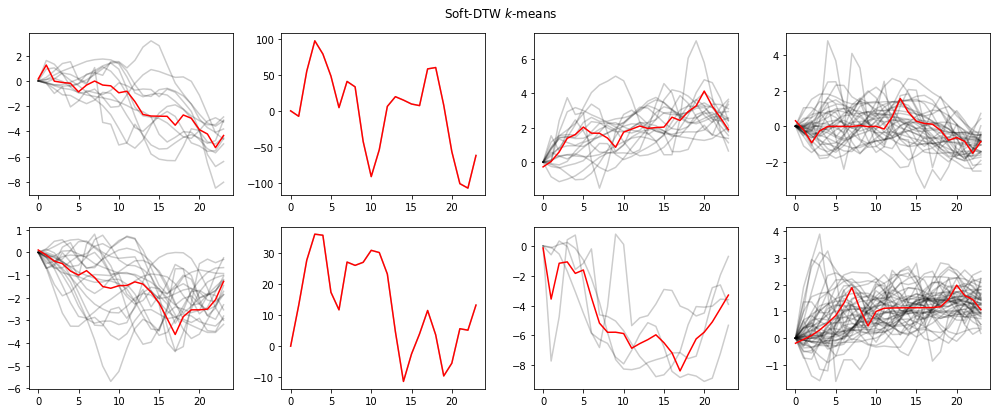

In [190]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_pred_sdtw == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

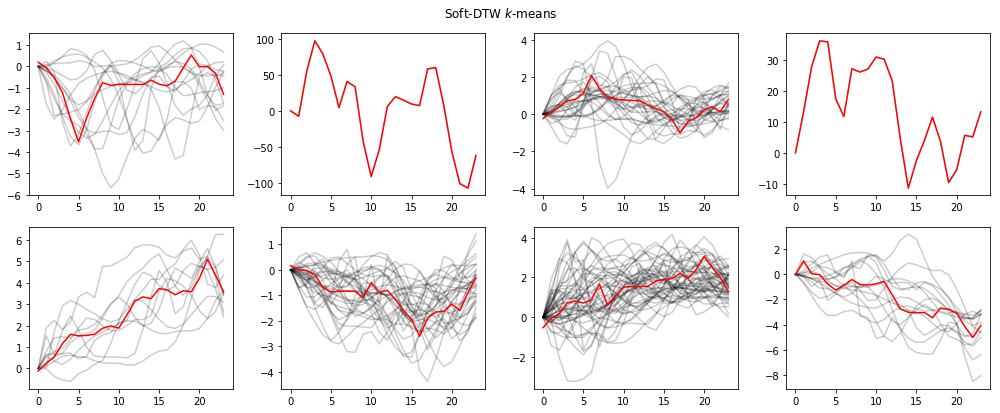

In [188]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_pred_sdtw == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Soft-DTW $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In order to make inferences robust to this stochasticity, we run the alogorithm 1000 times, to quantify which individuals tend to cluster together

In [13]:
iterations = 100

# (Use IPython parallel for this in production)

In [18]:
predictions = []
for i in range(iterations):
    if not i % 20:
        print('iteration', i)
    predictions.append(TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", 
                                        verbose=False,
                                        metric_params={"gamma_sdtw": .01}).fit_predict(data_interpolated.T.values))

In [19]:
comparisons = []
for i in range(N):
    counts = np.zeros(N)
    for row in predictions:
        current_cluster = row[i]
        counts += row==current_cluster
    comparisons.append(counts)
comparisons = np.array(comparisons)

Here is the correlation matrix among individuals. Brighter pixels are individuals that tend to end up in the same clusters based on 1000 clusterings.

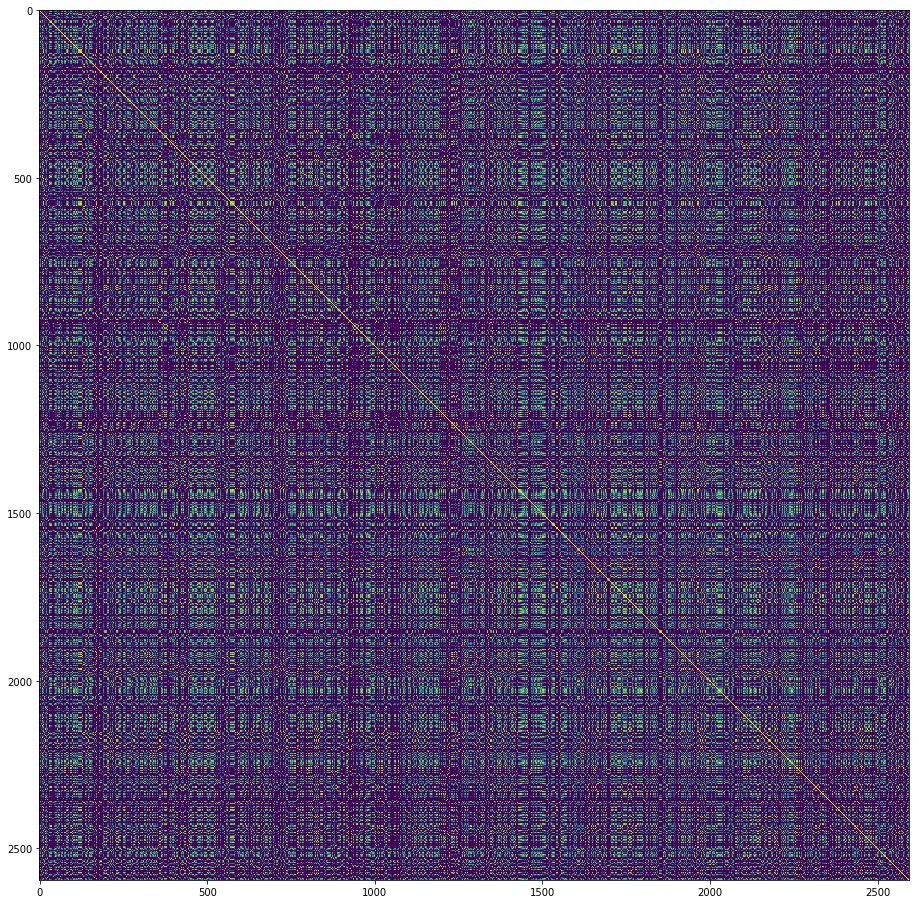

In [20]:
plt.figure(figsize=(16, 16))
plt.imshow(comparisons/iterations)

In [21]:
(comparisons > (iterations*0.7)).sum(1)

array([ 47, 202,  47, ...,  28, 256,  13])

In [22]:
correlations = comparisons/iterations

## Use DBSCAN to cluster based on the correlation matrix

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. 

In [1]:
from sklearn.cluster import DBSCAN
from tslearn.metrics import dtw

In [37]:
1 - correlations

array([[ 0.  ,  1.  ,  0.15, ...,  0.95,  1.  ,  1.  ],
       [ 1.  ,  0.  ,  1.  , ...,  1.  ,  0.81,  1.  ],
       [ 0.15,  1.  ,  0.  , ...,  1.  ,  1.  ,  1.  ],
       ..., 
       [ 0.95,  1.  ,  1.  , ...,  0.  ,  1.  ,  1.  ],
       [ 1.  ,  0.81,  1.  , ...,  1.  ,  0.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  0.  ]])

In [57]:
db_scanner = DBSCAN(eps=0.1, min_samples=1, metric='precomputed')
dbscan_pred = db_scanner.fit_predict((1-correlations))

In [58]:
np.unique(dbscan_pred)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

In [63]:
dbscan_clusters = [i for i in range(dbscan_pred.max()) if (dbscan_pred==i).sum()>6]
len(dbscan_clusters)

12

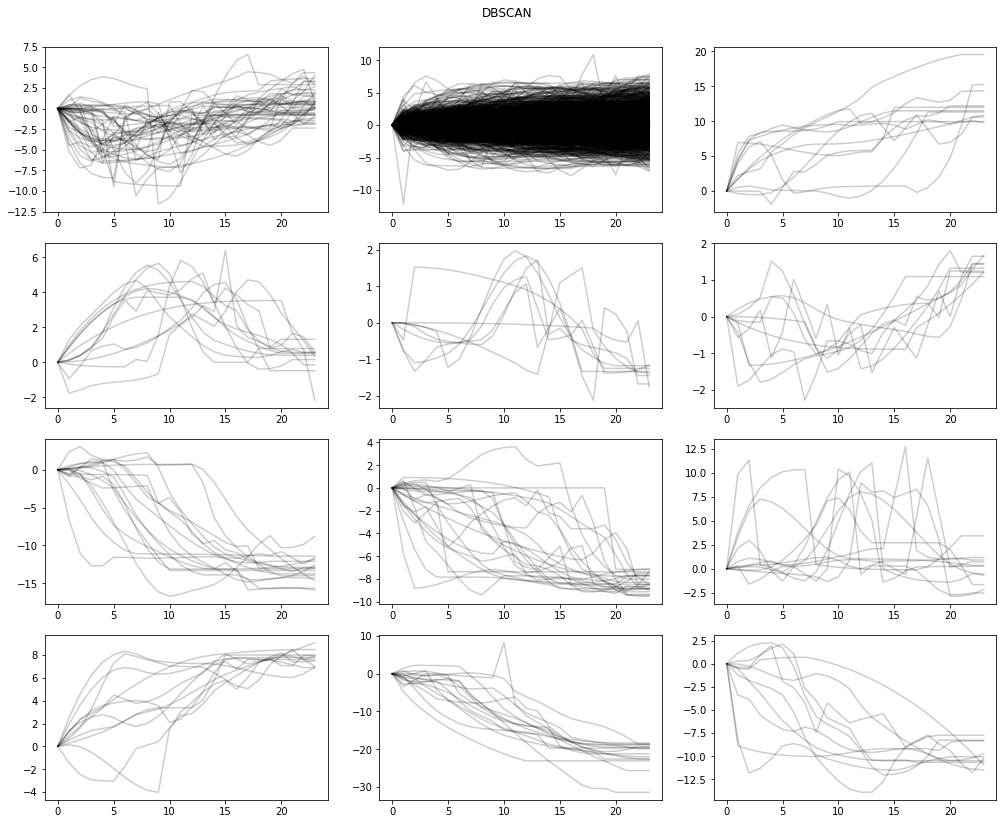

In [65]:
fig, axes = plt.subplots(4, 3, figsize=(14,12))
for i,ax in enumerate(axes.ravel()):
    for xx in data_interpolated.T.values[dbscan_pred == dbscan_clusters[i]]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
#     ax.plot(sdtw_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("DBSCAN")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Alternative clustering algorithms

K-means is not the only clustering approach we can use. For example, there are kernel-based methods.

In [23]:
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak

In [57]:
kernel_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters, 
                                        sigma=sigma_gak(mean_traj_centered), 
                                        n_init=20, 
                                        verbose=True)

y_kernel_pred = kernel_km.fit_predict(mean_traj_centered)


Init 1
384.568 --> 353.764 --> 348.295 --> 346.484 --> 343.610 --> 341.569 --> 340.391 --> 340.103 --> 339.579 --> 339.293 --> 338.903 --> 338.712 --> 338.560 --> 338.560 --> 
Init 2
384.332 --> 345.423 --> 340.332 --> 339.939 --> 339.238 --> 338.754 --> 338.576 --> 338.536 --> 338.536 --> 
Init 3
386.773 --> 355.949 --> 345.556 --> 344.413 --> 344.104 --> 343.683 --> 343.683 --> 
Init 4
384.937 --> 342.278 --> 340.811 --> 339.901 --> 338.960 --> 338.795 --> 338.731 --> 338.731 --> 
Init 5
385.275 --> 346.893 --> 345.268 --> 344.686 --> 344.365 --> 344.071 --> 343.638 --> 343.638 --> 
Init 6
383.247 --> 347.410 --> 340.532 --> 338.855 --> 338.625 --> 338.471 --> 338.471 --> 
Init 7
383.164 --> 352.445 --> 348.255 --> 346.949 --> 346.373 --> 345.408 --> 344.420 --> 343.732 --> 343.459 --> 343.208 --> 342.077 --> 340.313 --> 338.738 --> 338.408 --> 338.408 --> 
Init 8
387.065 --> 367.839 --> 361.253 --> 363.468 --> 364.514 --> 364.864 --> 365.163 --> 366.053 --> 365.580 --> 365.127 --> 3

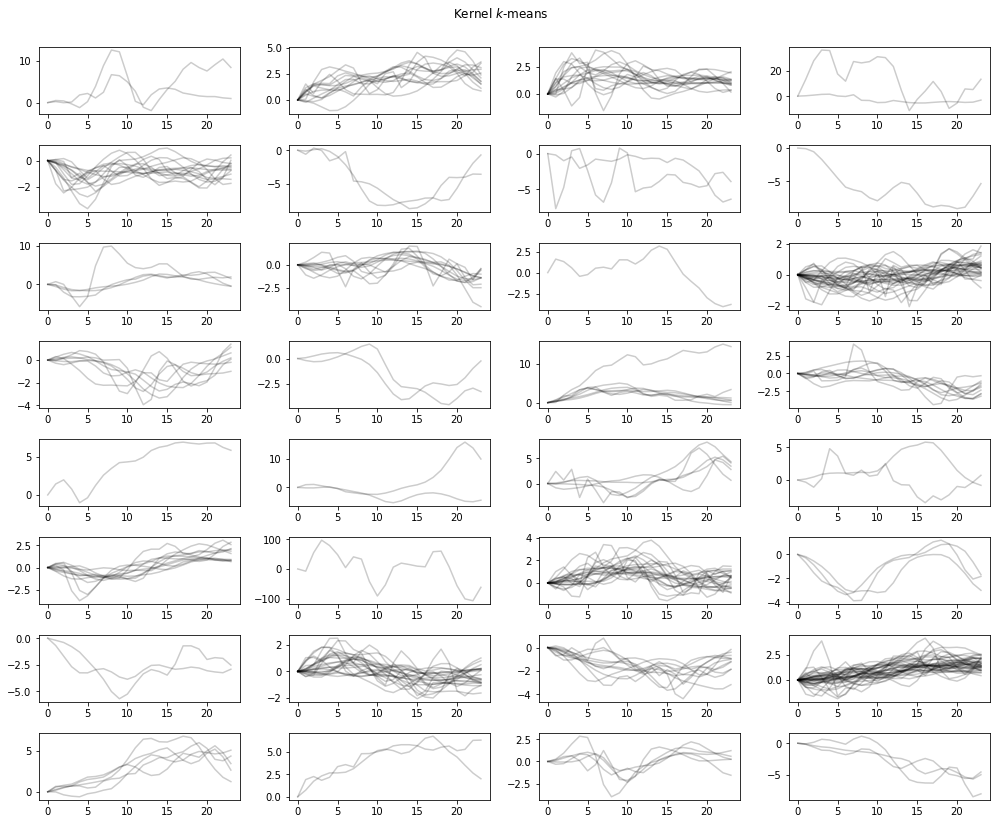

In [29]:
fig, axes = plt.subplots(8, 4, figsize=(14,12))
for i,ax in enumerate(axes.ravel()):
    for xx in mean_traj_centered[y_kernel_pred == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
#     ax.plot(kernel_km.cluster_centers_[i].ravel(), "r-")
fig.suptitle("Kernel $k$-means")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])